# KKBox Customer Lifetime Value Analysis

---

# Part 2: <font color=green>*Survival, Hazard, and LTV Analysis*</font>

---

In the previous article we discussed how, beyond prediction, customer retention inevitably comes down to understanding Customer Value and the price we are willing to pay to keep this value. In pursuit of this understanding and its respective implementation, we set out three questions that must be answered:

1) Which Customers Have the Highest Probability of Churning Soon?

2) What is the Lifetime Value for Each of Our Customers?

3) What Retention Offer is Most Appropriate for each Customer?

In addressing Question #1, we developed a churn prediction model that provided several strategies we can leverage in identifying high risk customers/members. As there is no single, optimal strategy due to the various trade-offs, the determination on which specific strategy to use would be based entirely on the amount we would be willing to invest as an attempt to prevent the existing members from leaving. 

"So how much should we invest into each of our high-risk customers" you ask? Well, that's completely dependent on how much we expect them to purchase and contribute over their lifetime. This expectation is referred to as a customer's Lifetime Value (LTV).

Just like the previous article, this article is written as a "follow-along" to my repo. Here, I will cover the main ideas, results, and inferences I came across over the course of this project. Now, let's go ahead and jump straight to Question #2:

### What is the Lifetime Value for Each of Our Customers?

**Lifetime Value (LTV) and Why is it important?**

Often when we think of customer acquisition and retention we immediately move into a cost minimizing (the floor) state of mind. Yet, how is it that when we hire talent we want the best and we are willing to pay (the ceiling) for the best? We need to apply this same exact logic to our Customer Acquisition and Retention efforts. We shouldn't be obsessing over pennies if there are dollars to be gained!

LTV, aka Value of Acquisition-Retention, is defined as the present value of the future (net) cash flows. This is a forward-looking concept and is not a measure of past profitability. 

So how do we calculate LTV? Well, it depends. All revenue streams can be boiled down to either a Contractual or Non-Contractual model. The main difference being that in a contractual setting we observe the time when our customers "die" (example: an application that offers a monthly subscription and a customer doesn't re-subscribe), whereas in a non-contractual setting, the time in which a customer becomes inactive is not observed (example: a customer making a purchase from an ecommerce site and never returning).

In [1]:
# General Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import datetime 
import time 

# Imports for CLV
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

# Formating
pd.options.display.float_format = '{:,}'.format

## Import and Prep Data

In [2]:
# Import Transaction Files
CLV_Feb2016 = pd.read_csv('D:\J-5 Local\CLV Data\CLV_Feb2016.csv')

## 1) Survival Analysis

Addressing the question 'how long would it be before a particular event occurs', Survival Analysis is a branch of statistics originally used in medical and biological disciplines to study the survival times of trial patients suffering from major diseases. Simply put, we refer to this as a 'time to event' analysis. This technique can be further applied not just to traditional death events, but to many different types of events of interest in different business domains.

Survival analysis works well in situations where we can define:

- A 'Birth' event: For our application, this will be when a customer enters a contract with a company. We use this to measure how long a user has been a member (Tenure).

- A 'Death' event: This occurs when a customer doesn't re-subscribe within 30 days of their February 2016 membership expiration date.

Keep in mind, however, that this is more of an Exploratory Data Analysis technique used to evaluate the expected lifetime of different cohort groups by visualizing their respective cumulative probabilities for survival over time. The visual representation of this function is typically referred to as the Kaplan-Meier curve, and it demonstrates the probability of an event (for example, survival) at a certain time interval. 
Similar to how we would conduct a bi-variate EDA to understand the behavior and potential effect of individual features before creating a regression model, we conduct a Survival Analysis before creating a Cox Proportional Hazards (CPH) Regression. Let's now see what information we can gather using a specific type of survival curves called Kaplan-Meier Curves.

### <font color=purple>Overall Population</font>

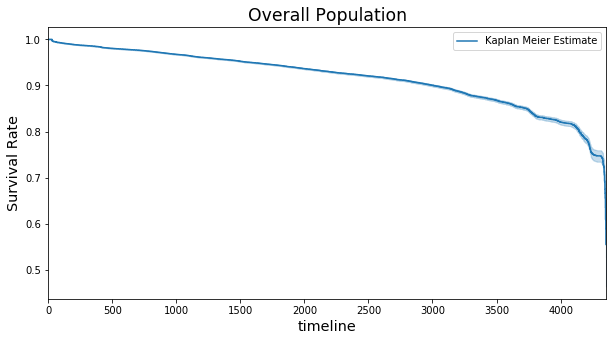

In [3]:
## Time to event data of censored and event data
T = CLV_Feb2016['tenure']

## It has the churned (1) and censored is (0)
E = CLV_Feb2016['is_churn'].apply(lambda x: True if x == 1 else False)

# Instantiate Model
kmf = KaplanMeierFitter()

## Fit the data into the model
kmf.fit(T, E, label='Kaplan Meier Estimate')

## Create an estimate
plt.figure(figsize=(10,5))
plt.title('Overall Population', fontsize='xx-large')
plt.ylabel('Survival Rate', fontsize='x-large')
plt.xlabel('Timeline (Days)', fontsize='x-large')
kmf.plot()

The curve above provides some intuition related to the health of our population. Overall, retention seems relatively strong with our members having an ~80% probability of survival at 4000 days. This shows that KKBox is quite a healthy business as the odds of a customer surviving are high. Let's now break up our data into various cohorts to develop a solid foundation before determining the Lifetime Value for our customers.

### <font color=purple>Survival Analysis #1 - Clusters</font>

We begin right where we left off in our customer segmentation analysis. In the previous project we identified 4 different cohorts based on user activity. They were as follows: 

***Cluster 3, The Power Users***

Small in numbers but Loyal, this segment of users was the most active across all metrics. As these users tend to have longer membership lengths than the others, their proportional churn was below 1%. This group also had the highest average revenue per user. 

***Cluster 2, Secondary Power Users***

In terms of activity, these users were a close second to our Power Users and contributed to roughly ~16% of the total observed revenue. Like our Cluster 0 users, they have a churn % sitting slightly above 1%. 

***Cluster 0, The Active Majority***

Coming in at third, in terms of activity, we have what we call 'The Active Majority'. Making up nearly 43% of our observed population these users are the strongest contributors to revenue making up 43% of total revenue. Although Cluster 2 users were more active, there was virtually no difference between them in terms of Churn % and Average Revenue Per User.

***Cluster 1, The Inactive Minority***

With the largest amount of churn compared to all other groups, we observed how this segment of customers is significantly less active than the rest of the other groups. What was interesting however was that these users were most likely to have received discounts on their subscriptions and yet many of them ended up churning. Even as we just saw in the previous section: ***34.5% of all users in Cluster 1 who currently underpaid their plan price, churned.*** This makes me question whether or not many of these people are even worth spending resources on and reinforces why Customer Lifetime Value is so important when determining who is worth going after.

I wish we had more data related to user demographics and how these users were acquired so we can have a better understanding of attribution. Given the current, and limited, dataset we were able to make strides on creating an initial customer segmentation model. In the next project, we will work on understanding Customer Lifetime Value and how it relates to these segments.

In [4]:
# Distribution of Clusters
CLV_Feb2016['Cluster'].value_counts()

1    244905
0    222082
2     71178
3      9959
Name: Cluster, dtype: int64

#### **Kaplan Curve for**: *Cluster Cohorts*

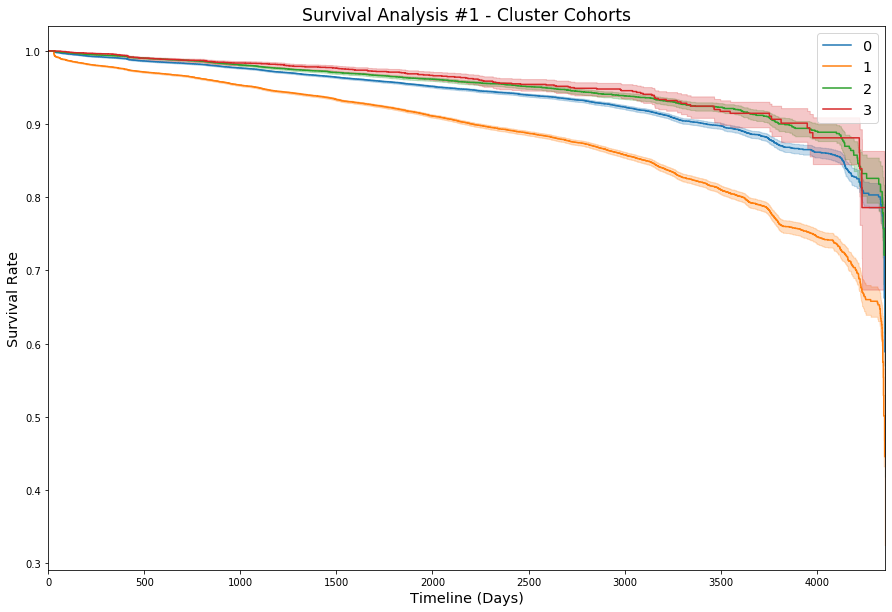

In [5]:
## Create the cohorts from the 'Cluster' column
plt.figure(figsize=(15,10))
ax = plt.subplot()
for c in np.unique(CLV_Feb2016['Cluster']):
    x = (CLV_Feb2016['Cluster'] == c)
    kmf.fit(T[x], E[x], label=c)
    kmf.plot(ax=ax)

# Plot Details
plt.title('Survival Analysis #1 - Cluster Cohorts', fontsize='xx-large')
plt.ylabel('Survival Rate', fontsize='x-large')
plt.xlabel('Timeline (Days)', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.show()

Here we see a clear separation between Cluster 1 (The Less-Active Minority) and the other cohorts. This is a solid follow-up to our segmentation analysis as it further demonstrates how Cluster 1 clearly has the worst expected lifetime of the group (75% Survival vs ~89% for the other groups @ 4000 days). However, in the long run, having your worst customers with 75% chance of survival at ~11 years is a GREAT problem to have.

### <font color=purple>Survival Analysis #2 - Registration Method</font>

Although KKBox doesn't provide much information on values for the Registration Method, I find it to be an interesting feature as it could potentially represent 'how' the user was on-boarded to the platform.

In [6]:
# Distribution of # of Unique payment plans
CLV_Feb2016['registered_via'].value_counts()

7     325424
9     135600
3      72911
4      14188
10         1
Name: registered_via, dtype: int64

According to the data there are only 5 different Registration Methods.

#### **Kaplan Curve for**: *Registration Method*

In [7]:
np.unique(CLV_Feb2016['registered_via'])

array([ 3,  4,  7,  9, 10], dtype=int64)

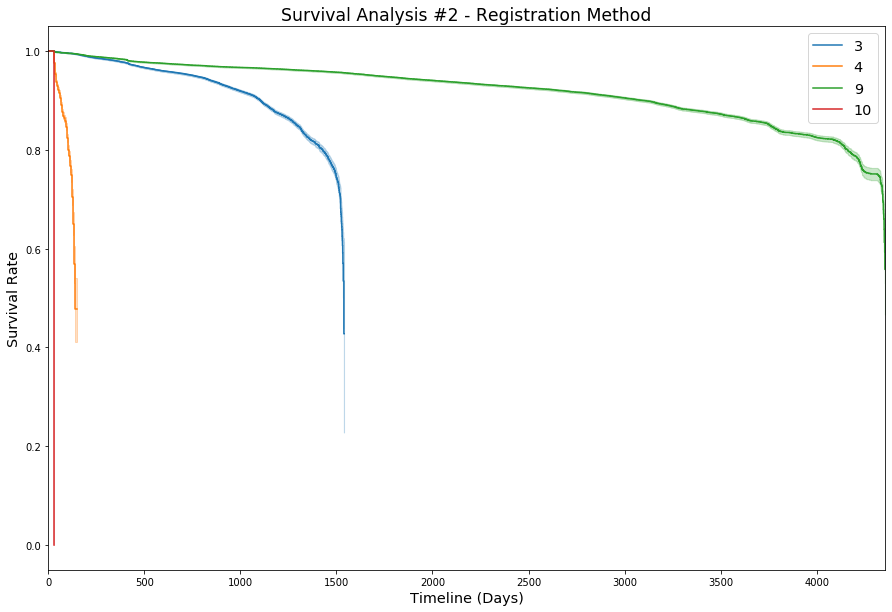

In [8]:
## Create the cohorts from the 'registered_via' column
plt.figure(figsize=(15,10))
ax = plt.subplot()
for c in [ 3,  4,  9, 10]:
    x = (CLV_Feb2016['registered_via'] == c)
    kmf.fit(T[x], E[x], label=c)
    kmf.plot(ax=ax)

# Plot Details
plt.title('Survival Analysis #2 - Registration Method', fontsize='xx-large')
plt.ylabel('Survival Rate', fontsize='x-large')
plt.xlabel('Timeline (Days)', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.show()

One of the luxuries of conducting a survival analysis is that we can clearly see the exact factors that contribute to both strong and weak members. Here we see a clear difference in survival rate over all 4 registration methods, with **registered_via = 9 and 3** outperforming the rest. Members with **registered_via = 10 and 4** seem to die almost instantly. If our assumption of this feature is true, then through attribution we could make a strong case for redistributing our resources in the former 2 methods to acquire more long-lasting members. 

From the perspective of process improvement, survival curves also act as a prompt in investigating why 4 and 10 performed so poorly. This is a great example of how we can use survival curves for **Optimizing User Acquisition** by evaluating marketing campaigns and the types of customers they produce for our company.

### <font color=purple>Survival Analysis #3 - Number of Unique Payment Plans</font>

Companies that utilize subscriptions usually offer various tiers for customers. Typically, one of those tiers are highlighted or distinguished as the company is purposely trying to lure customers to select a default package. With Survival Analysis we can ask the question: *How does the choice of what we default people into for these subscriptions impact how long they stay with us as customers?*

In [9]:
# Distribution of # of Unique payment plans
CLV_Feb2016['unique_payment_plans'].value_counts()

1    305268
2    230287
3     11878
4       608
5        78
6         5
Name: unique_payment_plans, dtype: int64

Looking at these values we see that Members with only 1 single plan throughout their lifetime are the majority.

#### **Kaplan Curve for**: *Number of Unique Payment Plans*

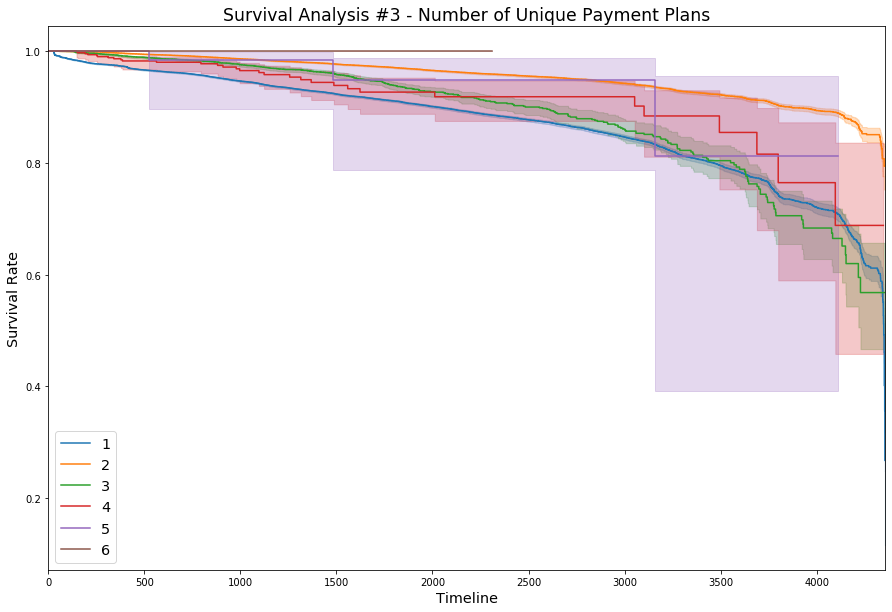

In [10]:
## Create the cohorts from the 'unique_payment_plans' column
plt.figure(figsize=(15,10))
ax = plt.subplot()
for c in np.unique(CLV_Feb2016['unique_payment_plans']):
    x = (CLV_Feb2016['unique_payment_plans'] == c)
    kmf.fit(T[x], E[x], label=c)
    kmf.plot(ax=ax)

# Plot Details
plt.title('Survival Analysis #3 - Number of Unique Payment Plans', fontsize='xx-large')
plt.ylabel('Survival Rate', fontsize='x-large')
plt.xlabel('Timeline', fontsize='x-large')
plt.legend(fontsize='x-large')

The only plot which seems significant compared to the rest is for members who have had only two unique payment splans over their tenure. The other plots really dont tell us much as their CI's seem to all cross over eachother. I do not expect this feature to valuable in determining Expected lifetime per user. Let's take a deeper look at which plans are associated with a lower survival rate for users who have a single plan.

### <font color=purple>Survival Analysis #4 - Payment Plan Durations for Members with a Single Plan</font>

For our first cohort we will look into the differences between members and the # of unique payment plans they have had

In [11]:
# Distribution of Payment Plan Durations
plan_duration = CLV_Feb2016[CLV_Feb2016['unique_payment_plans'] == 1]['payment_plan_days'].value_counts().reset_index()
plan_duration.columns = ['plan_duration','amount']
plan_duration.head(10)

,plan_duration,amount
0,30,296491
1,195,2200
2,410,1908
3,180,1414
4,10,1377
5,100,517
6,395,373
7,7,361
8,360,297
9,90,86


Month-to-Month is the most popular with other durations making up a just small fraction of the population. The durations themselves do not show any consistent pattern with respect to progression in duration length and thus seem a bit random. Lets take a look at a representative sample of the top 10 plan durations

#### **Kaplan Curve for**: *Payment Plan Durations for Members with a Single Plan*

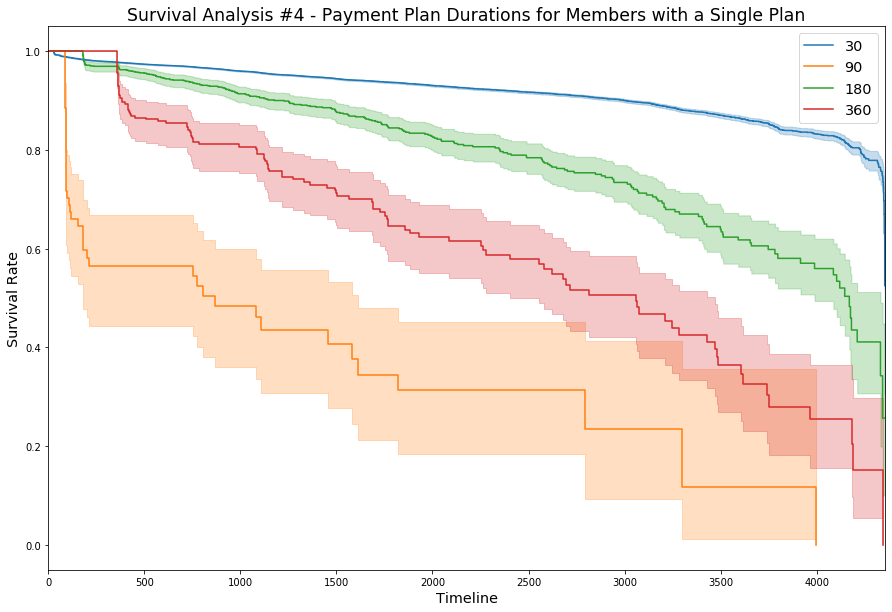

In [12]:
# Filter df to singple payment plan users, create temp variables for Tenure and Churn
temp = CLV_Feb2016[CLV_Feb2016['unique_payment_plans'] == 1]
T_temp = temp['tenure']
E_temp = temp['is_churn']

## Create the cohorts from the 'unique_payment_plans' column
plt.figure(figsize=(15,10))
ax = plt.subplot()
for c in [30,90,180,360]:
    x = (temp['payment_plan_days'] == c)
    kmf.fit(T_temp[x], E_temp[x], label=c)
    kmf.plot(ax=ax)

# Plot Details
plt.title('Survival Analysis #4 - Payment Plan Durations for Members with a Single Plan', fontsize='xx-large')
plt.ylabel('Survival Rate', fontsize='x-large')
plt.xlabel('Timeline', fontsize='x-large')
plt.legend(fontsize='x-large')

The larger Plan Durations have significant drop offs after each of their respective intervals. Members with a 180 day plan are a perfect example of this as once their plan expires their survival rate plummets. This makes me believe that once their plan expires, people with large plan durations are less willing to resubscribe at the same High, bundled rate. These users immediately churn with out consideration of other plans.

### <font color=purple>Survival Analysis #5 - Registrations via City</font>

In [13]:
# # Distribution of Cities
# plan_duration = CLV_Feb2016.value_counts().reset_index()
# plan_duration.columns = ['City','amount']
# plan_duration.head(10)

City 1 is the most popular.

#### **Kaplan Curve for**: *Payment Plan Durations for Members with a Single Plan*

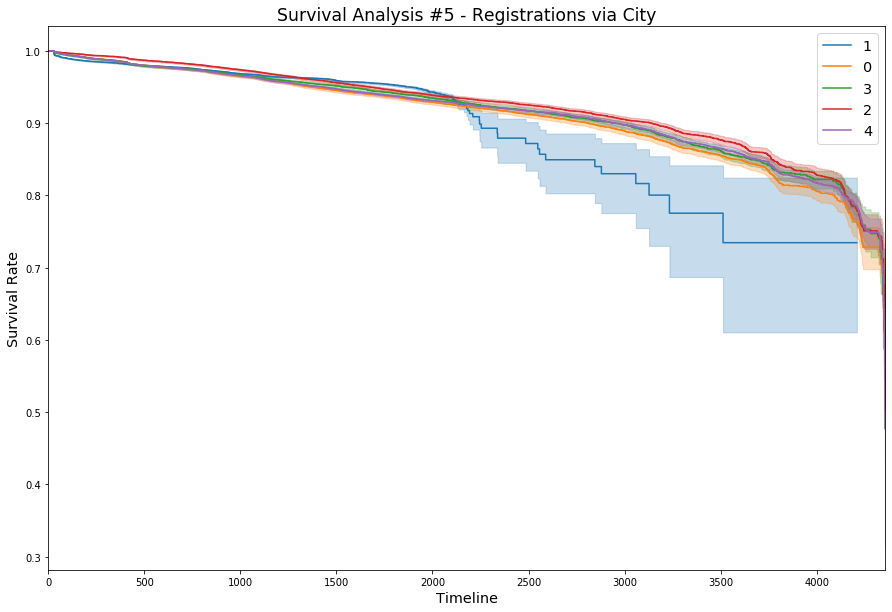

In [14]:
## Create the cohorts from the 'unique_payment_plans' column
plt.figure(figsize=(15,10))
ax = plt.subplot()
for c in CLV_Feb2016['city_agg'].unique():
    x = (CLV_Feb2016['city_agg'] == c)
    kmf.fit(T[x], E[x], label=c)
    kmf.plot(ax=ax)

# Plot Details
plt.title('Survival Analysis #5 - Registrations via City', fontsize='xx-large')
plt.ylabel('Survival Rate', fontsize='x-large')
plt.xlabel('Timeline', fontsize='x-large')
plt.legend(fontsize='x-large')

The larger Plan Durations have significant drop offs after each of their respective intervals. Members with a 180 day plan are a perfect example of this as once their plan expires their survival rate plummets. This makes me believe that once their plan expires, people with large plan durations are less willing to resubscribe at the same High, bundled rate. These users immediately churn with out consideration of other plans.

## 2) Cox Proportional Hazard Model (Survival Regression)

As previously discussed, our Kaplan Meier curves work with only one feature and ignore the effects of all other features. Hence arises the need for a better model that can simultaneously assess the impact of all numeric and multiple predictors on survival times. 

Cox Proportional Hazards (CPH) is a commonly used, semi-parametric model used for investigating the relationship between the survival time and all our variables (including categorical and quantitative predictors). It returns the Expected lifetime for each user by cumulatively calculating an individual's risk of "death" over time for a given rate of hazard. These 'Hazards' can be thought of as something that would increase/decrease chances of survival. In our business problem, for example, a hazard may be the associated likelihood of death (customer churn) due to the type of contract a customer has or the way they registered for the app.

We must emphasize again that the main point of running a CPH regression model is not to analyze who dies and who does not die. Rather, we do this to study effects of our features (also called covariates) on the timing of death. The result of said study is the ability to predict a user's expected lifetime, which we then in turn use to calculate their respective lifetime value.

### - <font color=blue>Data Pre-Processing</font> -

In [15]:
# Specify the Continuous and Categorical features we will include in our regression model
cont_feat = ['tenure','unique_payment_plans']
cat_feat = ['registered_via','Cluster','city_agg']

# Create df for regression model
CLV_Feb2016 = CLV_Feb2016[['msno','avg_paid_per_day','is_churn'] + cont_feat + cat_feat]

# Encode Categoricals
CLV_Feb2016 = pd.get_dummies(data=CLV_Feb2016, columns=cat_feat, prefix_sep='_',drop_first=True)

# Use PCA to make 1 component for 'registered_via' to prevent multicolinearity errors
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
CLV_Feb2016['registered_via_PCA'] = pca.fit_transform(CLV_Feb2016[['registered_via_4','registered_via_7','registered_via_9','registered_via_10']]).round(decimals=3)

CLV_Feb2016 = CLV_Feb2016.drop(['registered_via_4','registered_via_7','registered_via_9','registered_via_10'], axis=1)

### - <font color=blue>Build CPH Regression Model via Lifelines</font> -

In [16]:
# Instantiate a cph object
cph_lifelines = CoxPHFitter()   

# Fit the data to train the model
model_lifelines = cph_lifelines.fit(CLV_Feb2016[CLV_Feb2016.columns[2:]], duration_col='tenure', event_col='is_churn')

In [17]:
model_lifelines.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
unique_payment_plans,-0.9984319586910484,0.36845674383083493,0.01487123916431115,-1.0275790518585797,-0.969284865523517,0.35787230295868927,0.37935423041132327,-67.13845078136747,0.0,inf
Cluster_1,0.7400524914823328,2.096045536143969,0.015808562237720692,0.7090682788490403,0.7710367041156252,2.032097028554356,2.1620064533604237,46.813396459071974,0.0,inf
Cluster_2,-0.25642672588616405,0.7738116928482579,0.027653182214870703,-0.3106259670852342,-0.20222748468709392,0.7329879862359672,0.816909072498663,-9.272955419512938,1.810581140530671e-20,65.58210906563454
Cluster_3,-0.3426935820799215,0.709855690743061,0.06673833128791967,-0.4734983077925467,-0.21188885636729632,0.6228196379594895,0.8090546138384345,-5.134883888563042,2.8231826784623797e-07,21.75617418055858
city_agg_1,0.6473557193343277,1.9104822924781408,0.02950711998730089,0.589522826871716,0.7051886117969394,1.8031278059484745,2.02422844228316,21.938966582063347,1.1038122428132555e-106,351.98188326583454
city_agg_2,-0.24474480015474112,0.7829043098086632,0.026294830233946895,-0.29628172039287193,-0.1932078799166103,0.7435779174468308,0.8243105987084498,-9.307715546258713,1.3061124797311858e-20,66.0532827535713
city_agg_3,-0.09777491977386685,0.9068529954618435,0.02748325181675381,-0.15164110351274934,-0.043908736034984366,0.8592966239460078,0.9570412968709524,-3.5576183060791657,0.00037423256936240716,11.383777258135614
city_agg_4,-0.086366601802419,0.9172579011744637,0.02363178707511937,-0.1326840533599721,-0.04004915024486588,0.8757417360631473,0.9607422172766172,-3.6546792474001983,0.0002575037063462682,11.92311918185981
registered_via_PCA,1.0747862320918276,2.929366629021155,0.01835125072898345,1.0388184415917556,1.1107540225918995,2.825876103328941,3.0366472320261835,58.56746485373558,0.0,inf


The resulting model summary is quite elaborate, so for now we will only focus on the key output: exp(coef). This is interpreted as the scaling of hazard (risk) for each additional unit of the variable:

- **1        --> No Effect**
- **Below 1  --> Decrease in Hazard**
- **Above 1  --> Increase in Hazard**

Interpreting the summary

- The hazard ratio (HR) given under exp(coef) against each predictor shows that city_agg_4 and city_agg_3 feature with exp(coef) = ~.9 have a minimal effect on hazard.

- Cluster_2 and Cluster_3 features with exp(coef) = .77 and .71 respectively (i.e., less than 1) which means a decrease in hazard and hence better survival. So, a member being classified as either one of the clusters reduces the hazard by a factor of .77 and .71 respectively and thus a good prognostic for better survival.

- city_agg_1, Cluster_1, registered_via_PCA have hazard ratios = ~2 and above! These are significant "killers".

### - <font color=blue>Feature Engineering: Cumulative Hazard Prob, Lifetime, Lifetime Value</font> -

#### <font color=purple>*Current Cummulative Harzard Probability For Each User*</font>

In [18]:
# # Calculate each member's Cummulative Hazard Probability with respect to their current tenure
# def cumul_hazard_prob(row):
#     if row['tenure'] > 4306:
#         cumul_hazard_prob = model_lifelines.predict_cumulative_hazard(row).iloc[row['tenure']-(row['tenure']-4306)]
#         return list(cumul_hazard_prob)[0]
#     else:
#         cumul_hazard_prob = model_lifelines.predict_cumulative_hazard(row).iloc[row['tenure']]
#         return list(cumul_hazard_prob)[0]

In [19]:
# # Calculate each member's Cummulative Hazard Probability with respect to their current tenure
# start = time.time()
# CLV_Feb2016['Current Hazard Prob'] = CLV_Feb2016.apply(lambda x: cumul_hazard_prob(x), axis=1)
# end = time.time()
# print('Time spent for training: {}'.format(round(end-start)))

#### <font color=purple>*Total Expected Lifetime*</font>

In [20]:
# Calculate Total Expected Lifetime
start = time.time()
lt1 = model_lifelines.predict_expectation(CLV_Feb2016.iloc[0:100000])
lt2 = model_lifelines.predict_expectation(CLV_Feb2016.iloc[100000:200000])
lt3 = model_lifelines.predict_expectation(CLV_Feb2016.iloc[200000:300000])
lt4 = model_lifelines.predict_expectation(CLV_Feb2016.iloc[300000:400000])
lt5 = model_lifelines.predict_expectation(CLV_Feb2016.iloc[400000:500000])
lt6 = model_lifelines.predict_expectation(CLV_Feb2016.iloc[500000:])
CLV_Feb2016['LT'] = pd.concat([lt1,lt2,lt3,lt4,lt5,lt6])
end = time.time()
print('Time spent for training: {}'.format(round(end-start)))

Time spent for training: 99


#### <font color=purple>*Total Expected Lifetime Value as Net Present Value*</font>

In [22]:
# Function to calculate NPV for a given expected Lifetime.
def npv_calc(disc_rate, LT):
    if LT > 0:
        range_init = int((LT/ 365) - ((LT % 365)/365))
        range_last = ((LT % 365)/365) * 114
        temp_list = [114 for i in range(0,range_init)]
        temp_list.insert(range_init+1, range_last)
        return np.npv(disc_rate,temp_list)
    
    else:
        return 0

In [23]:
# Calculate Lifetime Value as Net Present Value with a 10% discount rate
CLV_Feb2016['LTV'] = CLV_Feb2016['LT'].apply(lambda x: npv_calc(.1, x))

#### <font color=purple>*Remaining Lifetime*</font>

In [24]:
# Calculate remaining LT given each member's current tenure
CLV_Feb2016['LT_remaining'] = CLV_Feb2016['LT'] - CLV_Feb2016['tenure']

#### <font color=purple>*Remaining Lifetime Value*</font>

In [26]:
# Calculate remaining LTV 
CLV_Feb2016['LTV_remaining'] = CLV_Feb2016['LT_remaining'].apply(lambda x: npv_calc(.1, x))

### - <font color=blue>Visualize Tenure, Expected and Remaining Lifetime and Lifetime Value</font> -

#### <font color=purple>*Observed Tenure*</font>

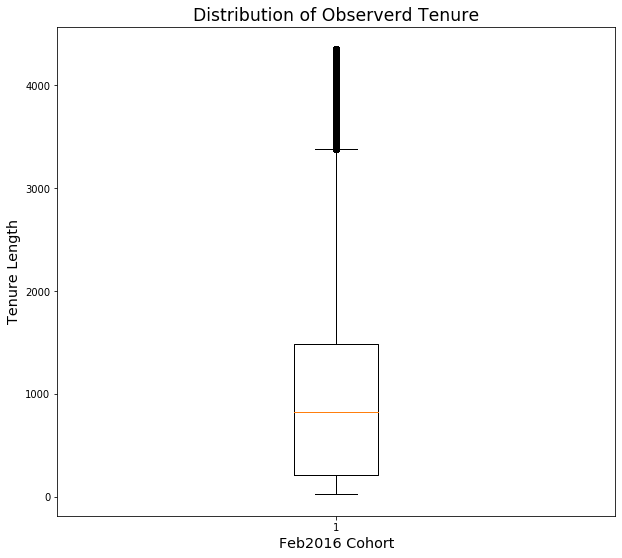

In [27]:
# Distribution of Tenure
plt.figure(figsize=(10,9))
plt.boxplot(CLV_Feb2016['tenure'])

# Plot Details
plt.title('Distribution of Observerd Tenure', fontsize='xx-large')
plt.ylabel('Tenure Length', fontsize='x-large')
plt.xlabel('Feb2016 Cohort', fontsize='x-large')
plt.show()

In [28]:
# 5-Number Summary of Observed Tenure
CLV_Feb2016['tenure'].describe()

count           548,124.0
mean    999.2016642219644
std     907.6398605195648
min                  30.0
25%                 214.0
50%                 821.0
75%               1,482.0
max               4,355.0
Name: tenure, dtype: float64

#### <font color=purple>*Expected Lifetime*</font>

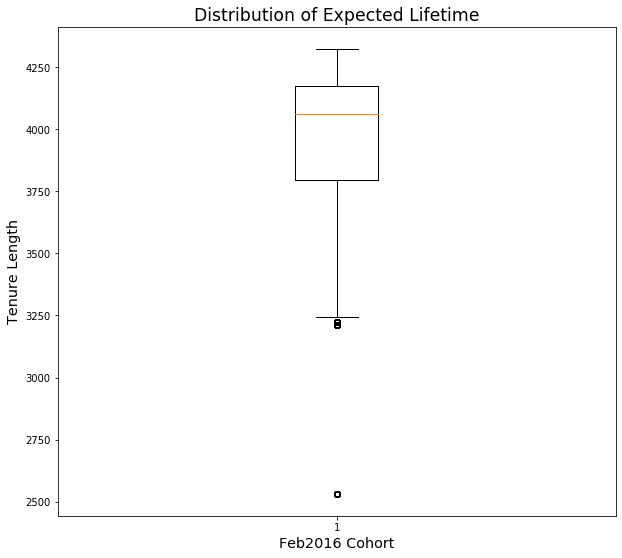

In [29]:
# Distribution of Expected Lifetime
plt.figure(figsize=(10,9))
plt.boxplot(CLV_Feb2016['LT'])

# Plot Details
plt.title('Distribution of Expected Lifetime', fontsize='xx-large')
plt.ylabel('Tenure Length', fontsize='x-large')
plt.xlabel('Feb2016 Cohort', fontsize='x-large')
plt.show()

In [30]:
# 5-Number Summary of Expected Lifetime
CLV_Feb2016['LT'].describe()

count             548,124.0
mean     3,988.610215135801
std      252.52026856580855
min       2,533.27762610711
25%     3,796.7107562386445
50%     4,060.3499225575333
75%      4,172.934161562505
max      4,323.400826339208
Name: LT, dtype: float64

#### <font color=purple>*Expected Lifetime Value*</font>

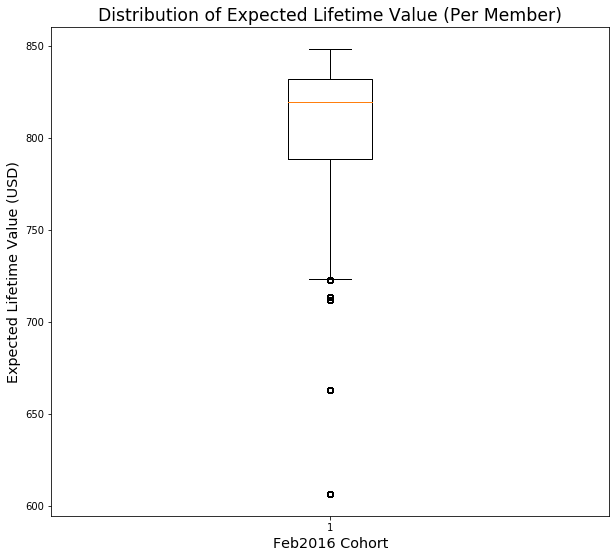

In [31]:
# Distribution of Expected Lifetime
plt.figure(figsize=(10,9))
plt.boxplot(CLV_Feb2016['LTV'])

# Plot Details
plt.title('Distribution of Expected Lifetime Value (Per Member)', fontsize='xx-large')
plt.ylabel('Expected Lifetime Value (USD)', fontsize='x-large')
plt.xlabel('Feb2016 Cohort', fontsize='x-large')
plt.show()

In [32]:
# 5-Number Summary of our Complete LTV Value
CLV_Feb2016['LTV'].describe()

count            548,124.0
mean     809.8795907248324
std     31.742512275160315
min      606.6700337967716
25%      788.1950756615678
50%      819.4450755753036
75%      831.7695965073193
max      848.2410811129857
Name: LTV, dtype: float64

In [33]:
# Median LTV
CLV_Feb2016['LTV'].median()

819.4450755753036

As mentioned earlier, Expected Lifetime Value is calculated as the present value of the future (net) cash flows. We calculate this assuming a weighted average monthly cost of 9.50 (~0.32 per day, USD conversion) at an arbitrary yearly discount rate of 10% (in practice, discount rates are usually 6–12%,).

With a total LTV of 819.45 over 4000 days, we see how mass adoption is critical for this business model to be successful. It is important to note that this calculation does not account for a member's tenure, meaning the Total LTV of 443,914,440.78 is inclusive of past value that our members have already contributed to the company. However, we are more interested in determining how much remaining value can we expect a member to contribute.

#### <font color=purple>*Expected Remaining Lifetime*</font>

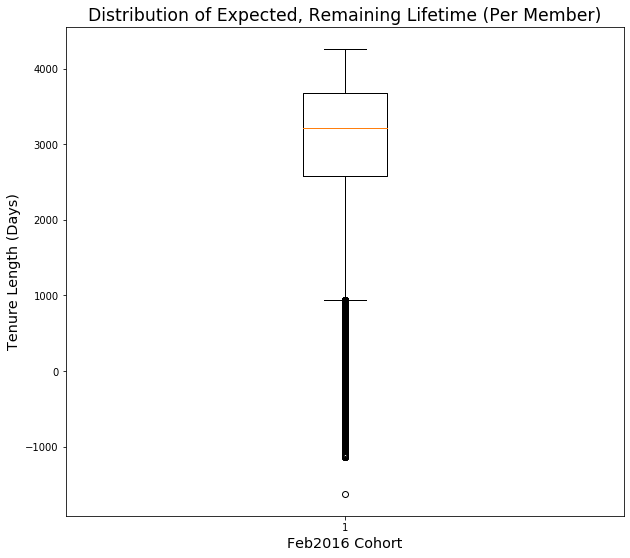

In [34]:
# Distribution of Expected, Remaining Lifetime'
plt.figure(figsize=(10,9))
plt.boxplot(CLV_Feb2016['LT_remaining'])

# Plot Details
plt.title('Distribution of Expected, Remaining Lifetime (Per Member)', fontsize='xx-large')
plt.ylabel('Tenure Length (Days)', fontsize='x-large')
plt.xlabel('Feb2016 Cohort', fontsize='x-large')
plt.show()

In [35]:
# 5-Number Summary of our Complete LTV Value
CLV_Feb2016['LT_remaining'].describe()

count              548,124.0
mean     2,989.4085509130173
std        918.5503158102631
min     -1,622.7223738928901
25%        2,581.98633188631
50%       3,217.386965239085
75%      3,673.7107562386445
max       4,262.796979157065
Name: LT_remaining, dtype: float64

#### <font color=purple>*Expected Remaining Lifetime Value*</font>

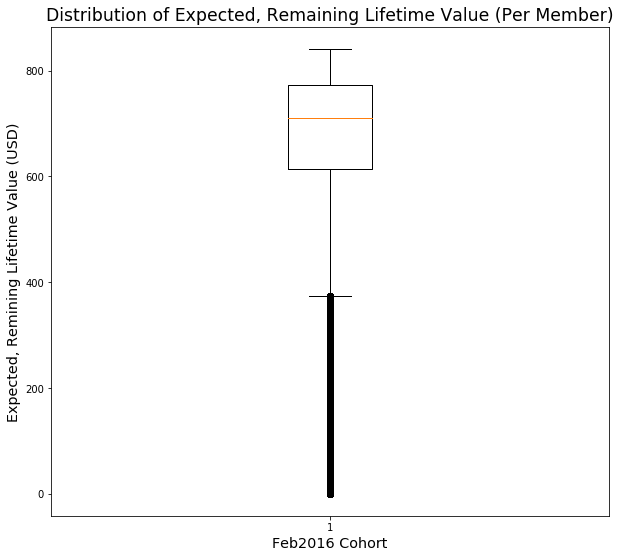

In [36]:
# Distribution of Expected Lifetime
plt.figure(figsize=(10,9))
plt.boxplot(CLV_Feb2016['LTV_remaining'])

# Plot Details
plt.title('Distribution of Expected, Remaining Lifetime Value (Per Member)', fontsize='xx-large')
plt.ylabel('Expected, Remining Lifetime Value (USD)', fontsize='x-large')
plt.xlabel('Feb2016 Cohort', fontsize='x-large')
plt.show()

In [37]:
# 5-Number Summary of our Remaining LTV
CLV_Feb2016['LTV_remaining'].describe()

count            548,124.0
mean     658.3048665904885
std     170.08934653107735
min                    0.0
25%       613.926138117447
50%      709.9316294180644
75%      773.3838756495653
max      841.6068187174827
Name: LTV_remaining, dtype: float64

In [38]:
# 5-Number Summary of our Remaining LTV
CLV_Feb2016['LTV_remaining'].median()

709.9316294180644

For our use-case, this is much more valuable, as we now have a realistic perspective on what to expect over time. In addition, we can see how LTV dips into the negatives and thus we can identify living users who were expected to be dead based on our estimate for Lifetime. To understand this better, it helps to interpret them as an absolute value representing the additional amount of value these members have contributed past their respective LTV amounts. 

This is just another great insight LTV modeling offers as these members could potentially belong to Cluster 3 (The Power Users) and would be candidates for potential premium up-selling. Even from a company valuation standpoint, we can make a very strong argument as to what this company is actually worth based solely on this distribution.

#### <font color=purple>*How Many Members Have An Expected, Remaining Lifetime Less Than Zero?*</font>

In [39]:
# Number of users with Expected, Remaining LT less than 0 Days
CLV_Feb2016[CLV_Feb2016['LT_remaining'] < 0].shape[0]

6138

6,138 members who are predicted to be dead but are still alive.

#### <font color=purple>*What Is The Complete LTV Value For Current Member Population?*</font>

In [40]:
# Total LTV of February 2016 Users:
print(f"Total LTV of February 2016 Users: ${round(CLV_Feb2016['LTV'].sum(),2):,}")

Total LTV of February 2016 Users: $443,914,440.78


#### <font color=purple>*What Is The Complete Remaining LTV Value Of Each Cohort?*</font>

In [41]:
# 5-Number Summary of our Complete LTV Remaining
print(f"Total LTV Remaining of February 2016 Users: ${round(CLV_Feb2016['LTV_remaining'].sum(),2):,}")

Total LTV Remaining of February 2016 Users: $360,832,696.69


### <font color=blue>Conclusion #1: How can we use all of this information to improve our overall Acquisition and Activation efforts?</font>

We started this article with the need to understand LTV so we could determine how much we can spend to convince a high-risk customer to reconsider their exit. This cost was crucial as it would spell out the trade-off posed by each of our model strategies in terms of cost and potential gains. While executing this calculation, we were actually able to get a little more in terms of value through the calculation.

**Optimizing Customer Acquisition and Activation**

One of the luxuries of conducting a survival analysis is that we can clearly see the exact factors contributing to both strong and weak members, allowing us to redistribute resources as necessary to better focus acquisition efforts.

Although it is commonly believed that long-term plans are best for business, this analysis made a strong case for the opposite using relatively limited data. Insights such as this which make survival analyses invaluable for all businesses.

**Cost of Acquisition vs Value of Acquisition**

As I mentioned before, we often seek to minimize costs in customer acquisition and retention yet are willing to pay a premium for the best talent. LTV is a valuable tool that can be used to find and acquire the Best Members. We shouldn't be obsessing over pennies when there are dollars to be gained!

In [42]:
# 5-Number Summary for LT and LTV
pd.DataFrame([CLV_Feb2016['LTV'].describe(),CLV_Feb2016['LT'].describe()])

,count,mean,std,min,25%,50%,75%,max
LTV,"548,124.0",809.8795907248324,31.742512275160315,606.6700337967716,788.1950756615678,819.4450755753036,831.7695965073193,848.2410811129857
LT,"548,124.0","3,988.610215135801",252.52026856580855,"2,533.27762610711","3,796.7107562386445","4,060.3499225575333","4,172.934161562505","4,323.400826339208"


In [43]:
# Median Values for LT and LTV
print(f"Median LT: {round(CLV_Feb2016['LT'].median(),2):,}")
print(f"Median LTV: ${round(CLV_Feb2016['LTV'].median(),2):,}")

Median LT: 4,060.35
Median LTV: $819.45


Now that we have these numbers it all comes down to a simple question: How much are we willing to pay Today for someone who can potentially pay us 1,400 Dollars over the next 11 years. That right there is our entire business model in one sentence. 

But there is this little thing which exists called Cash Flow and maybe 11 years is too long for our projections and we want to model to 3 years. It is simple, we know we are making around 127 Dollars per year per user and over the next three years each member could potentially brings us ~380 Dollars. Now we just need to decide what percentage of this potential amount of ~380 Dollars do we want to spend to acquire what will likely be a Good Member.

At this point of the project we have covered ideas on how CLV and its calculation can help our company in terms of Acquisition and Activation. In the next section we will focus on Customer Retention while taking our

## 3) Evaluate High-Risk Users From Churn Models

In the previous project, we set out to answer the question: Which Customers Have The Highest Probability of Churning Soon? And although we created several models that could easily answer this question, we still did not have enough information to select the best model for our business. We concluded that since we did not know each customer's worth, we couldn't properly determine what treatment would effectively convince them to stay with us. The cost of this treatment is what ultimately decides which model we should use, as these models gave us a clear understanding of risk and reward depending on the strategy. Now that we know how much our customers are worth to us, let's revisit our previous models and quantify the risk-reward trade-off between the two.

### - <font color=blue>Import Churn Model Data</font> -

In [54]:
# Cap LT_remaining @ 3 years
CLV_Feb2016['LT_remaining_3yearcap'] = CLV_Feb2016['LT_remaining'].apply(lambda x: x if x <= 1095 else 1095)
CLV_Feb2016['LTV_remaining_3yearcap'] = CLV_Feb2016['LT_remaining_3yearcap'].apply(lambda x: npv_calc(.1, x))

In [55]:
# Import Previous Model Results
gbt_1to175_results = pd.read_csv('D:\J-5 Local\CLV Data\gbt_1to175_results.csv')
gbt_13to1mean_results = pd.read_csv('D:\J-5 Local\CLV Data\gbt_13to1mean_results.csv')

# Merge Model Resutls to CLV Data
gbt_1to175_results = pd.merge(CLV_Feb2016, gbt_1to175_results, on='msno')
gbt_13to1mean_results = pd.merge(CLV_Feb2016, gbt_13to1mean_results, on='msno')

In [56]:
gbt_13to1mean_results = gbt_13to1mean_results.drop('Unnamed: 0', axis=1)
gbt_1to175_results = gbt_1to175_results.drop('Unnamed: 0', axis=1)

### - <font color=blue>Feature Engineering</font> -

#### <font color=purple>*True Positive, True Negative, False Positive, False Negative Label For Each Users*</font>

In [57]:
gbt_13to1mean_results['TP'] = gbt_13to1mean_results.apply(lambda x: 1 if x['is_churn']==0 and x['prediction']==0 else 0, axis=1)
gbt_13to1mean_results['TN'] = gbt_13to1mean_results.apply(lambda x: 1 if x['is_churn']==1 and x['prediction']==1 else 0, axis=1)
gbt_13to1mean_results['FN'] = gbt_13to1mean_results.apply(lambda x: 1 if x['is_churn']==1 and x['prediction']==0 else 0, axis=1)
gbt_13to1mean_results['FP'] = gbt_13to1mean_results.apply(lambda x: 1 if x['is_churn']==0 and x['prediction']==1 else 0, axis=1)

gbt_1to175_results['TP'] = gbt_1to175_results.apply(lambda x: 1 if x['is_churn']==0 and x['prediction']==0 else 0, axis=1)
gbt_1to175_results['TN'] = gbt_1to175_results.apply(lambda x: 1 if x['is_churn']==1 and x['prediction']==1 else 0, axis=1)
gbt_1to175_results['FN'] = gbt_1to175_results.apply(lambda x: 1 if x['is_churn']==1 and x['prediction']==0 else 0, axis=1)
gbt_1to175_results['FP'] = gbt_1to175_results.apply(lambda x: 1 if x['is_churn']==0 and x['prediction']==1 else 0, axis=1)   

### - <font color=blue>Re-Evaluate High Risk Members</font> -

#### <font color=purple>*If we did not intervene, and all of our actual churn members churned, what would be the total potential loss of value?*</font>

In [58]:
# Total LTV Remaining for Churned Memembers
print(f"Total LTV Remaining for Churned Memembers: ${round(CLV_Feb2016[CLV_Feb2016['is_churn'] == 1]['LTV_remaining_3yearcap'].sum(),2):,}")

Total LTV Remaining for Churned Memembers: $5,833,677.41


This effectively becomes the ceiling of how much value we are trying to svae through churn prediction.

#### <font color=purple>**For Each Model:** *What is the Risk And Reward in terms of CLV?*</font>
In other words, how much Value are we risking (FN), to have a chance in retaining (TN)

In [113]:
# Create a table for Risk Reward
risk_reward = pd.DataFrame(columns=['Model Cohort','# of Members Being Risked (FN)','Amount Being Risked (USD)','# of Members Being Potentially Saved (TN)','Potential Reward (USD)','# of At-Risk Users'])

# Create a table for Risk Reward @ 1-Month Treatment
risk_reward = risk_reward.append(pd.DataFrame(
                                              data=[['gbt_1to175_results', 
                                                     
                                                     # Amount of Members Being Risked (FN)
                                                     gbt_1to175_results[gbt_1to175_results['FN']==1].shape[0],
                                                     
                                                     # Amount Being Risked (USD)
                                                     round(gbt_1to175_results[gbt_1to175_results['FN']==1]['LTV_remaining_3yearcap'].sum(),2), 
                                                     
                                                     # Amount of Members Being Potentially Saved (TN)
                                                     gbt_1to175_results[gbt_1to175_results['TN']==1].shape[0], 
                                                     
                                                     # Potential Reward (USD)
                                                     round(gbt_1to175_results[gbt_1to175_results['TN']==1]['LTV_remaining_3yearcap'].sum(),2),
                                                     
                                                     # of At-Risk Users
                                                     gbt_1to175_results[gbt_1to175_results['prediction']==1].shape[0]]], 
    
                                              columns=['Model Cohort','# of Members Being Risked (FN)','Amount Being Risked (USD)','# of Members Being Potentially Saved (TN)','Potential Reward (USD)','# of At-Risk Users']))

risk_reward = risk_reward.append(pd.DataFrame(
                                              data=[['gbt_13to1mean_results', 
                                                     
                                                     # Amount of Members Being Risked (FN)
                                                     gbt_13to1mean_results[gbt_13to1mean_results['FN']==1].shape[0],
                                                     
                                                     # Amount Being Risked (USD)
                                                     round(gbt_13to1mean_results[gbt_13to1mean_results['FN']==1]['LTV_remaining_3yearcap'].sum(),2), 
                                                     
                                                     # Amount of Members Being Potentially Saved (TN)
                                                     gbt_13to1mean_results[gbt_13to1mean_results['TN']==1].shape[0], 
                                                     
                                                     # Potential Reward (USD)
                                                     round(gbt_13to1mean_results[gbt_13to1mean_results['TN']==1]['LTV_remaining_3yearcap'].sum(),2),
                                                     
                                                     # of At-Risk Users
                                                     gbt_13to1mean_results[gbt_13to1mean_results['prediction']==1].shape[0]]], 
    
                                              columns=['Model Cohort','# of Members Being Risked (FN)','Amount Being Risked (USD)','# of Members Being Potentially Saved (TN)','Potential Reward (USD)','# of At-Risk Users']))

In [114]:
# Show risk-reward table
risk_reward

,Model Cohort,# of Members Being Risked (FN),Amount Being Risked (USD),# of Members Being Potentially Saved (TN),Potential Reward (USD),# of At-Risk Users
0,gbt_1to175_results,2587,"763,721.89",17336,"5,069,955.52",94020
0,gbt_13to1mean_results,11651,"3,424,135.92",8272,"2,409,541.49",15754


Now that we have included Remaining LTV into the picture, we can get a clear sense now of the trade off presented by each model.

**GBT 1 to 1 Ratio Model - Too Many False Negatives**

In this model, we give up on 2,618 members, leaving 764K on the table so we can have a chance at retaining 17,305 members with a remaining LTV of 5.07 Million over three years. However, this comes with a catch. In order to reach all 17,305 members, we would have to re-approach the 94,020 members who were Marked as High-Risk.

**GBT 13 to 1 Ratio Model - Too Many False Positive**

This model essentially gives up on 11,670 members, leaving 3.24 Million on the table so we can have a chance at retaining 8,253 members with a remaining LTV of 2.41 Million. The advantage of this model is that we only have 15,559 members identified as Actually High-Risk. This means that "proportionally" compared to other models, we don't need to approach as many people to reach those users who are Actually High-Risk.

#### <font color=purple>**For Each Model:** *Evaluate each model given some arbitrary treatment costs*</font>

Let's evaluate each model at two different treatment costs to better understand them.

#### Risk Reward Table: 1-Month Free Subscription as Treatment

Assumptions:
- Treatment cost is 9.50 Dollars (1 Month Subscription)
- We will only approach users with an LTV equal to thrice the amount of the treatment as we are interested in only getting a gross return of atleast 200%.
- Potential Reward is Total LTV Remaining for all users
- All members recieve the same treatment

In [115]:
# Create a table for Risk Reward @ 1-Month Treatment
risk_reward_1month_treatment = pd.DataFrame(columns=['Model Cohort','# of Members Being Risked (FN)','Amount Being Risked (USD)','# of Members Being Potentially Saved (TN)','Potential Reward (USD)','# of At-Risk Users'])

# Create a table for Risk Reward @ 1-Month Treatment
risk_reward_1month_treatment = risk_reward_1month_treatment.append(pd.DataFrame(
                                              data=[['gbt_1to175_results', 
                                                     
                                                     # Amount of Members Being Risked (FN)
                                                     gbt_1to175_results[(gbt_1to175_results['FN']==1) & (gbt_1to175_results['LTV_remaining_3yearcap'] > 28.5)].shape[0],
                                                     
                                                     # Amount Being Risked (USD)
                                                     round(gbt_1to175_results[(gbt_1to175_results['FN']==1) & (gbt_1to175_results['LTV_remaining_3yearcap'] > 28.5)]['LTV_remaining_3yearcap'].sum(),2), 
                                                     
                                                     # Amount of Members Being Potentially Saved (TN)
                                                     gbt_1to175_results[(gbt_1to175_results['TN']==1) & (gbt_1to175_results['LTV_remaining_3yearcap'] > 28.5)].shape[0],
                                                     
                                                     # Potential Reward (USD)
                                                     round(gbt_1to175_results[(gbt_1to175_results['TN']==1) & (gbt_1to175_results['LTV_remaining_3yearcap'] > 28.5)]['LTV_remaining_3yearcap'].sum(),2),
                                                     
                                                     # of At-Risk Users
                                                     gbt_1to175_results[(gbt_1to175_results['prediction']==1) & (gbt_1to175_results['LTV_remaining_3yearcap'] > 28.5)].shape[0]]], 
    
                                              columns=['Model Cohort','# of Members Being Risked (FN)','Amount Being Risked (USD)','# of Members Being Potentially Saved (TN)','Potential Reward (USD)','# of At-Risk Users']))

risk_reward_1month_treatment = risk_reward_1month_treatment.append(pd.DataFrame(
                                              data=[['gbt_13to1mean_results', 
                                                     
                                                     # Amount of Members Being Risked (FN)
                                                     gbt_13to1mean_results[(gbt_13to1mean_results['FN']==1) & (gbt_13to1mean_results['LTV_remaining_3yearcap'] > 28.5)].shape[0],
                                                     
                                                     # Amount Being Risked (USD)
                                                     round(gbt_13to1mean_results[(gbt_13to1mean_results['FN']==1) & (gbt_13to1mean_results['LTV_remaining_3yearcap'] > 28.5)]['LTV_remaining_3yearcap'].sum(),2), 
                                                     
                                                     # Amount of Members Being Potentially Saved (TN)
                                                     gbt_13to1mean_results[(gbt_13to1mean_results['TN']==1) & (gbt_13to1mean_results['LTV_remaining_3yearcap'] > 28.5)].shape[0],
                                                     
                                                     # Potential Reward (USD)
                                                     round(gbt_13to1mean_results[(gbt_13to1mean_results['TN']==1) & (gbt_13to1mean_results['LTV_remaining_3yearcap'] > 28.5)]['LTV_remaining_3yearcap'].sum(),2),
                                                     
                                                     # of At-Risk Users
                                                     gbt_13to1mean_results[(gbt_13to1mean_results['prediction']==1) & (gbt_13to1mean_results['LTV_remaining_3yearcap'] > 28.5)].shape[0]]], 
    
                                              columns=['Model Cohort','# of Members Being Risked (FN)','Amount Being Risked (USD)','# of Members Being Potentially Saved (TN)','Potential Reward (USD)','# of At-Risk Users']))


# Total Cost of Treatment
risk_reward_1month_treatment['Total Treatment Cost'] = risk_reward_1month_treatment['# of At-Risk Users'] * 9.5

# Potential ROI
risk_reward_1month_treatment['Potential ROI'] = risk_reward_1month_treatment['Potential Reward (USD)'] / risk_reward_1month_treatment['Total Treatment Cost']

In [116]:
risk_reward_1month_treatment

,Model Cohort,# of Members Being Risked (FN),Amount Being Risked (USD),# of Members Being Potentially Saved (TN),Potential Reward (USD),# of At-Risk Users,Total Treatment Cost,Potential ROI
0,gbt_1to175_results,2528,"763,549.29",16797,"5,068,342.39",91944,"873,468.0",5.802550740267531
0,gbt_13to1mean_results,11343,"3,423,252.07",7982,"2,408,639.61",15195,"144,352.5",16.68581846521536


#### Risk Reward: 3-Month Free Subscription as Treatment

Assumptions:
- Treatment cost is 28.5 Dollars (3 Month Subscription)
- We will only approach users with an LTV equal to thrice the amount of the treatment as we are interested in only getting a gross return of atleast 200%.
- Potential Reward is Total LTV Remaining for all users
- All members recieve the same treatment

In [ ]:
# Create a table for Risk Reward @ 1-Month Treatment
risk_reward_1month_treatment = pd.DataFrame(columns=['Model Cohort','# of Members Being Risked (FN)','Amount Being Risked (USD)','# of Members Being Potentially Saved (TN)','Potential Reward (USD)','# of At-Risk Users'])

# Create a table for Risk Reward @ 1-Month Treatment
risk_reward_1month_treatment = risk_reward_1month_treatment.append(pd.DataFrame(data=[['gbt_1to175_results', 
                                                     gbt_1to175_results[(gbt_1to175_results['prediction']==1) & (gbt_1to175_results['LTV_remaining'] > 85.5)].shape[0],
                                                     round(gbt_1to175_results[(gbt_1to175_results['prediction']==1) & (gbt_1to175_results['LTV_remaining'] > 85.5)]['LTV_remaining'].sum(),2), 
                                                     gbt_1to175_results[gbt_1to175_results['TN']==1].shape[0], 
                                                     round(gbt_1to175_results[(gbt_1to175_results['prediction']==1) & (gbt_1to175_results['LTV_remaining'] > 85.5)]['LTV_remaining'].sum(),2),
                                                     gbt_1to175_results[(gbt_1to175_results['prediction']==1) & (gbt_1to175_results['LTV_remaining'] > 85.5)].shape[0]]], 
                                              columns=['Model Cohort','# of Members Being Risked (FN)','Amount Being Risked (USD)','# of Members Being Potentially Saved (TN)','Potential Reward (USD)','# of At-Risk Users']))

risk_reward_1month_treatment = risk_reward_1month_treatment.append(pd.DataFrame(data=[['gbt_13to1mean_results', 
                                                     gbt_13to1mean_results[(gbt_13to1mean_results['prediction']==1) & (gbt_13to1mean_results['LTV_remaining'] > 85.5)].shape[0],
                                                     round(gbt_13to1mean_results[(gbt_13to1mean_results['prediction']==1) & (gbt_13to1mean_results['LTV_remaining'] > 85.5)]['LTV_remaining'].sum(),2), 
                                                     gbt_13to1mean_results[gbt_13to1mean_results['TN']==1].shape[0], 
                                                     round(gbt_13to1mean_results[(gbt_13to1mean_results['prediction']==1) & (gbt_13to1mean_results['LTV_remaining'] > 85.5)]['LTV_remaining'].sum(),2),
                                                     gbt_13to1mean_results[(gbt_13to1mean_results['prediction']==1) & (gbt_13to1mean_results['LTV_remaining'] > 85.5)].shape[0]]], 
                                              columns=['Model Cohort','# of Members Being Risked (FN)','Amount Being Risked (USD)','# of Members Being Potentially Saved (TN)','Potential Reward (USD)','# of At-Risk Users']))

# Total Cost of Treatment
risk_reward_1month_treatment['Total Treatment Cost'] = risk_reward_1month_treatment['# of At-Risk Users'] * 28.5

# Potential ROI
risk_reward_1month_treatment['Potential ROI'] = risk_reward_1month_treatment['Potential Reward (USD)'] / risk_reward_1month_treatment['Total Treatment Cost']

In [ ]:
risk_reward_1month_treatment

### <font color=blue>Conclusion #2: Which Model Do We Choose?</font>

Well assuming that we have zero data on previous treatments and their succeses, while also working with a theoretically limited budget, it would be wise to start with the cheapest option. The most important key here is that we treatment as an investment and thus record all treatments and there effects. By building such a dataset, the investment is not just in retaining customers but in potentially building a model were we could customize our treatmeants to each of our members based on their profile and behaviour and what has been successfull with other customers. Furthermore, we can now combine our churn model with our ltv model in an attempt to quantify the dollar value for every point increase of our churn model accuracy.

The more I read about Lifetime Value and its respective use case the more I become fascinated with this topic. In leveraging LTV I believe that everything I laid out here in this project has added a new and fresh perspective on how we approach churn modeling projects especially since they aren't as one dimensional as many assume them to be. What was most impressive about this project was the amount of inference that we were about to derive with respect to customer Activation. Activation, and Retention. It shows us how Lifetime Value is an invaluable tool and I do not understand how any business can function without it. Personally, I feel that it is not talk about enough. I couldn't be happier on who we have been able to close out this three project series. Cheers!